In [5]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Dense, Activation, Lambda, Flatten
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.models import load_model
from keras.models import model_from_json
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

import os
import utils
from utils import LRN2D

import matplotlib.pyplot as plt

import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 4]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [6]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

In [7]:
def extensions(path):
    extension = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            extension.append(ext)
    return np.array(extension)

extension = extensions('images')

In [8]:
(pd.Series(extension)).value_counts()

.jpg    164
dtype: int64

In [9]:
def load_metadata(path):
  metadata = []
  for i in os.listdir(path):
    for f in os.listdir(os.path.join(path, i)):
      ext = os.path.splitext(f)[1]
      if ext == '.jpg' or ext == '.jpeg' or ext=='.JPG' or ext=='.png':
        metadata.append(IdentityMetadata(path, i, f))
  return np.array(metadata)

metadata = load_metadata('images')

In [10]:
len(metadata)

164

In [11]:
metadata[0]

images\adeolu\adeolu_0_1416.jpg

In [12]:
names = np.array([m.name for m in metadata])

In [13]:
pd.Series(names).value_counts()[:5]

demola    41
laide     41
labake    41
adeolu    41
dtype: int64

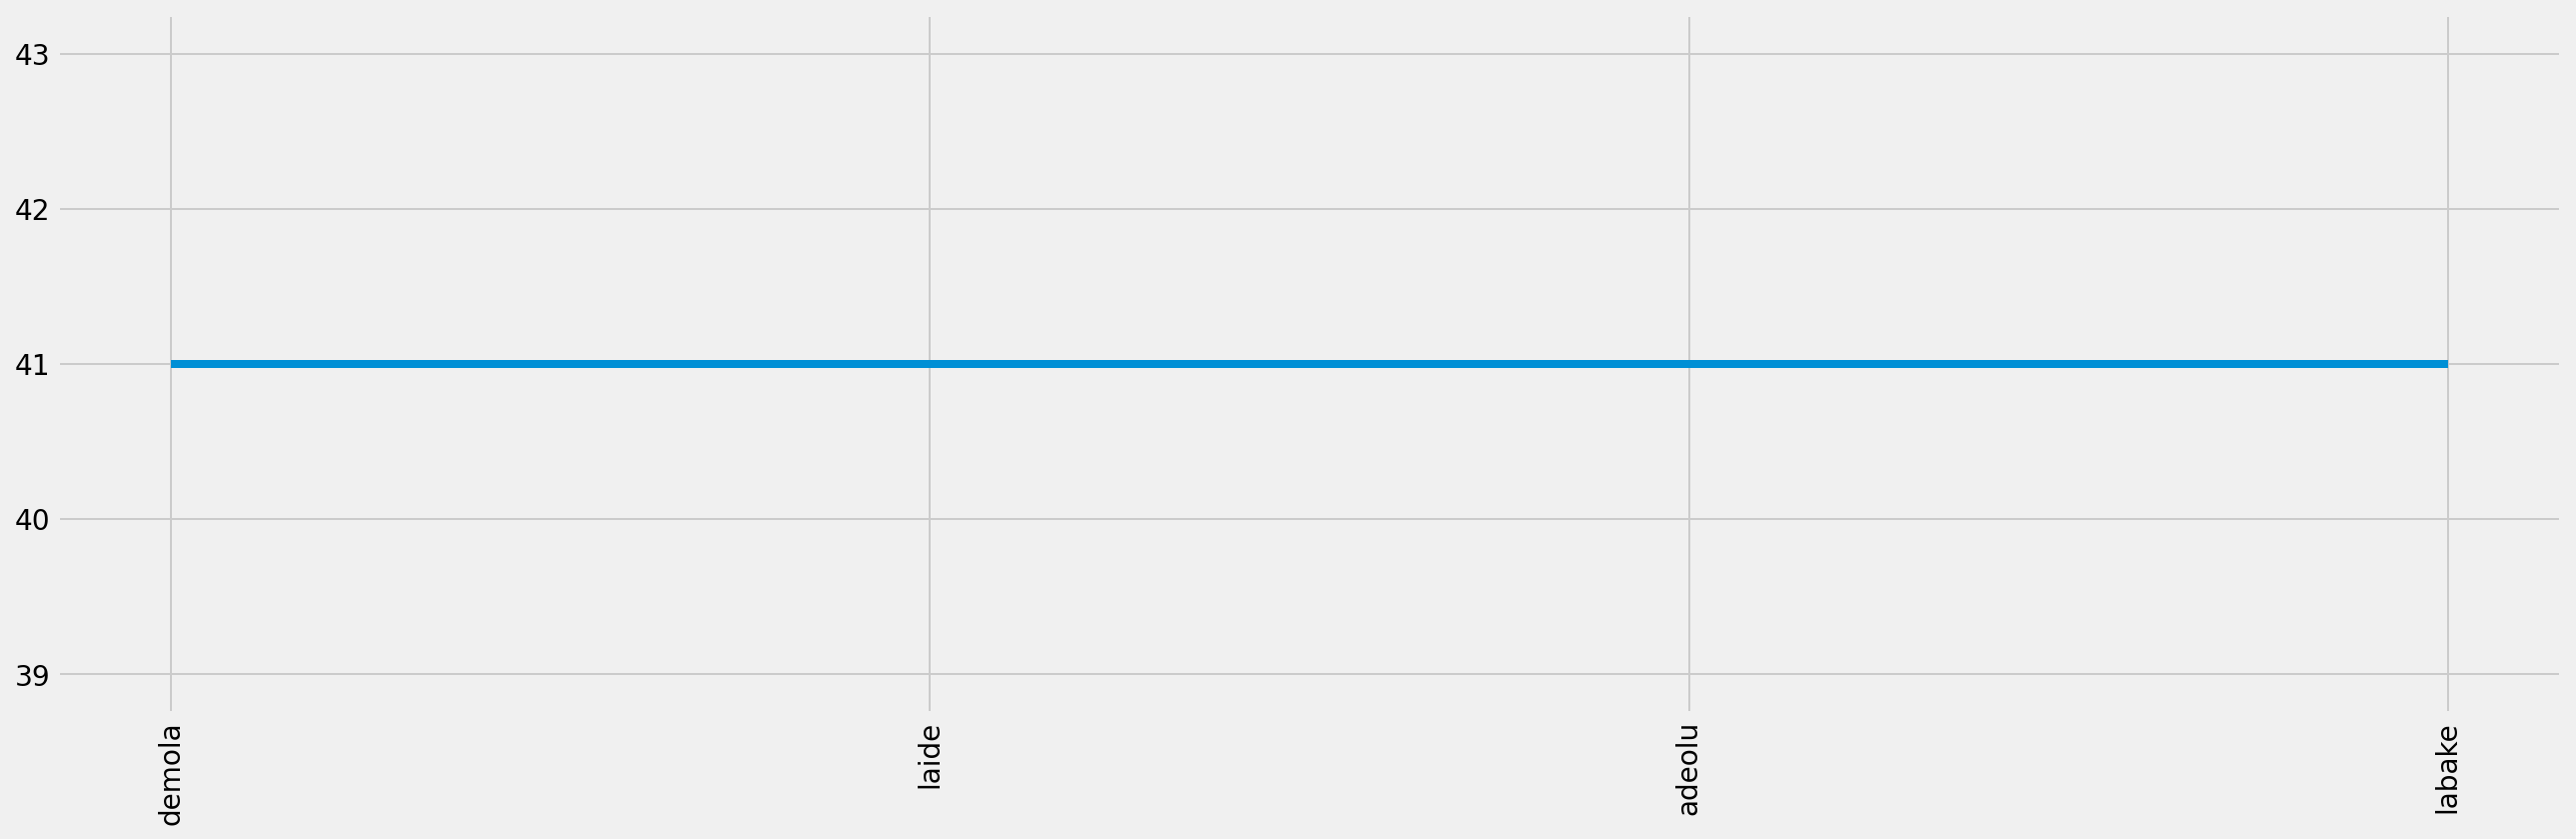

In [12]:
plt.figure(figsize=(20,6))
plt.plot(pd.Series(names).value_counts())
plt.xticks(rotation=90)
plt.grid(b=True)
plt.show()

In [14]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_cols, img_rows) 
else:
    input_shape = (img_cols, img_rows, 3)

### For the OpenFace We loaded the pretrained model like so since it is not inbuilt in Keras

In [15]:
def model_creator(top_model):
    myInput = Input(shape=(96, 96, 3))

    x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = utils.conv2d_bn(inception_3b,
                                       layer='inception_3c_3x3',
                                       cv1_out=128,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))

    inception_3c_5x5 = utils.conv2d_bn(inception_3b,
                                       layer='inception_3c_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = utils.conv2d_bn(inception_3c,
                                       layer='inception_4a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=192,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_4a_5x5 = utils.conv2d_bn(inception_3c,
                                       layer='inception_4a_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(1, 1),
                                       padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = utils.conv2d_bn(inception_4a_pool,
                                        layer='inception_4a_pool',
                                        cv1_out=128,
                                        cv1_filter=(1, 1),
                                        padding=(2, 2))
    inception_4a_1x1 = utils.conv2d_bn(inception_3c,
                                       layer='inception_4a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = utils.conv2d_bn(inception_4a,
                                       layer='inception_4e_3x3',
                                       cv1_out=160,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))
    inception_4e_5x5 = utils.conv2d_bn(inception_4a,
                                       layer='inception_4e_5x5',
                                       cv1_out=64,
                                       cv1_filter=(1, 1),
                                       cv2_out=128,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = utils.conv2d_bn(inception_4e,
                                       layer='inception_5a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e)
    inception_5a_pool = utils.conv2d_bn(inception_5a_pool,
                                        layer='inception_5a_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1),
                                        padding=(1, 1))
    inception_5a_1x1 = utils.conv2d_bn(inception_4e,
                                       layer='inception_5a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = utils.conv2d_bn(inception_5a,
                                       layer='inception_5b_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = utils.conv2d_bn(inception_5b_pool,
                                        layer='inception_5b_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = utils.conv2d_bn(inception_5a,
                                       layer='inception_5b_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Dense(units=4, activation = "sigmoid")(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)


In [16]:
conv_base=model_creator('./models/open_face.h5')

In [17]:
config = conv_base.get_config() # Returns pretty much every information about your model
print(config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

(None, 96, 96, 3)


In [18]:
print(conv_base.summary())
print('No. of hidden layers after addition of extra layers= {}'.format(len(conv_base.layers)))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Run SPLITFOLDERS once

In [21]:
nb_train_samples = 96
nb_validation_samples = 32
epochs = 300
batch_size = 16

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_data_dir = "../datasets/split_small_dataset/train/"
val_data_dir = "../datasets/split_small_dataset/val/"
test_data_dir = "../datasets/split_small_dataset/test/"


train_datagen = ImageDataGenerator(rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')
val_set = test_datagen.flow_from_directory(val_data_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 96 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 36 images belonging to 4 classes.


In [23]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
                   
checkpoint = ModelCheckpoint("./saved/small_dataset_openface.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 3,
                              min_lr=0.00000001,
                              verbose = 1,
                              min_delta = 0.00001)


# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# we use a small learning rate 
conv_base.compile(optimizer=RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy','mse','mae','cosine'])


history = conv_base.fit_generator(
    training_set,
    # set steps per epoch equal to the number of training images
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_set,
    validation_steps = nb_validation_samples // batch_size)

conv_base.save("./saved/small_dataset_openface.h5")

Epoch 1/300
6/6 [==============================] - 22s 4s/step - loss: 0.1342 - acc: 0.9896 - mean_squared_error: 0.0212 - mean_absolute_error: 0.0779 - cosine_proximity: -0.9856 - val_loss: 0.5390 - val_acc: 0.8438 - val_mean_squared_error: 0.0649 - val_mean_absolute_error: 0.1311 - val_cosine_proximity: -0.8485

Epoch 00001: val_loss improved from inf to 0.53896, saving model to ./saved/small_dataset_openface.h5
Epoch 2/300
6/6 [==============================] - 15s 2s/step - loss: 0.0947 - acc: 1.0000 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0672 - cosine_proximity: -0.9954 - val_loss: 0.5212 - val_acc: 0.7812 - val_mean_squared_error: 0.0686 - val_mean_absolute_error: 0.1304 - val_cosine_proximity: -0.8406

Epoch 00002: val_loss improved from 0.53896 to 0.52116, saving model to ./saved/small_dataset_openface.h5
Epoch 3/300
6/6 [==============================] - 15s 2s/step - loss: 0.0936 - acc: 0.9896 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0586 - cosine_

6/6 [==============================] - 15s 2s/step - loss: 0.0269 - acc: 1.0000 - mean_squared_error: 0.0200 - mean_absolute_error: 0.0544 - cosine_proximity: -0.9987 - val_loss: 0.1041 - val_acc: 0.9375 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.0814 - val_cosine_proximity: -0.9701
Restoring model weights from the end of the best epoch

Epoch 00022: val_loss did not improve from 0.06382
Epoch 00022: early stopping


In [28]:
conv_base.evaluate_generator(test_set, steps=50)

[0.10822526208664242,
 0.9720394736842105,
 0.0340329166086265,
 0.06490186202082489,
 -0.9684569318043558]

In [36]:
conv_base.metrics_names

['loss',
 'acc',
 'mean_squared_error',
 'mean_absolute_error',
 'cosine_proximity']

### Plot

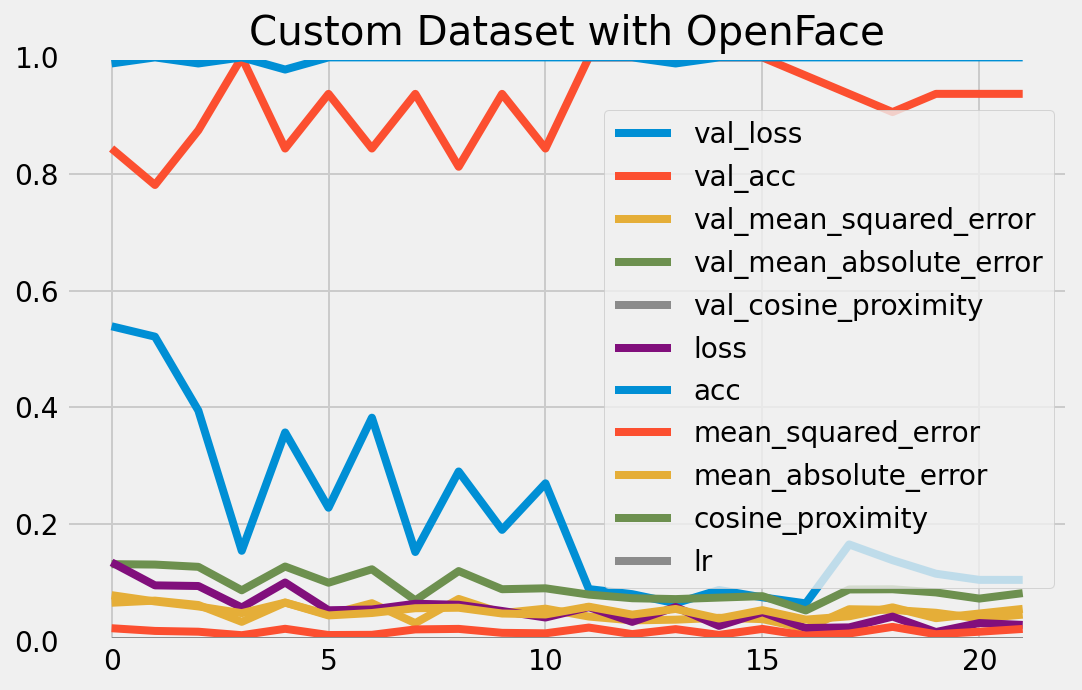

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title('Custom Dataset with OpenFace')
plt.show()

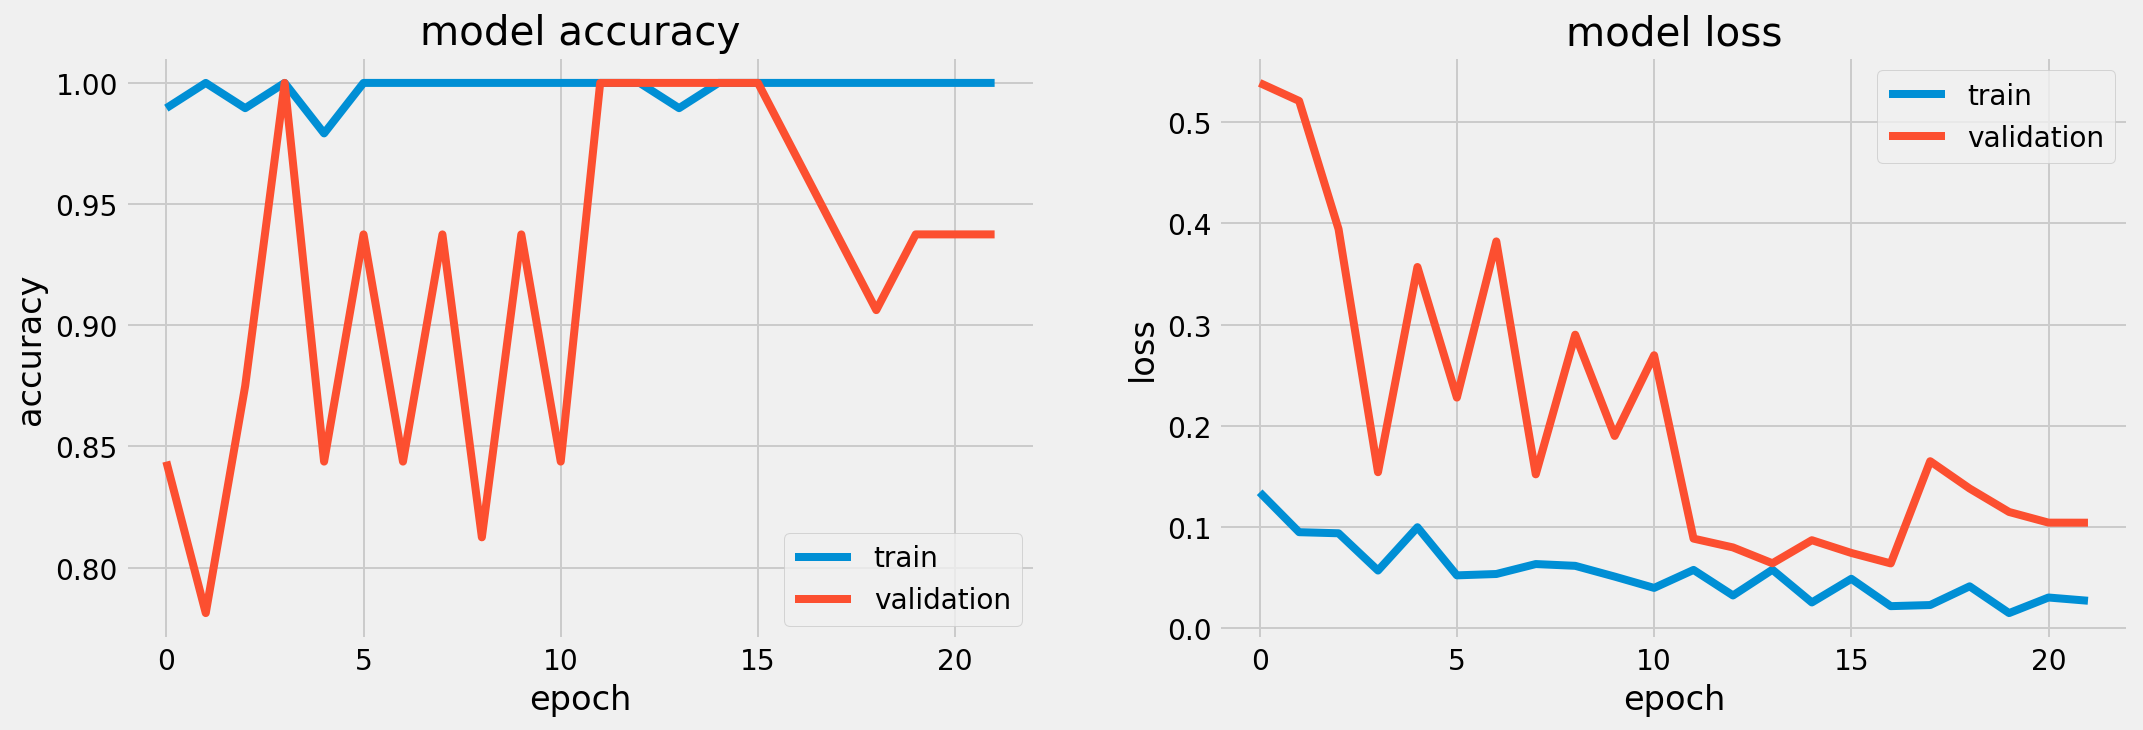

In [25]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

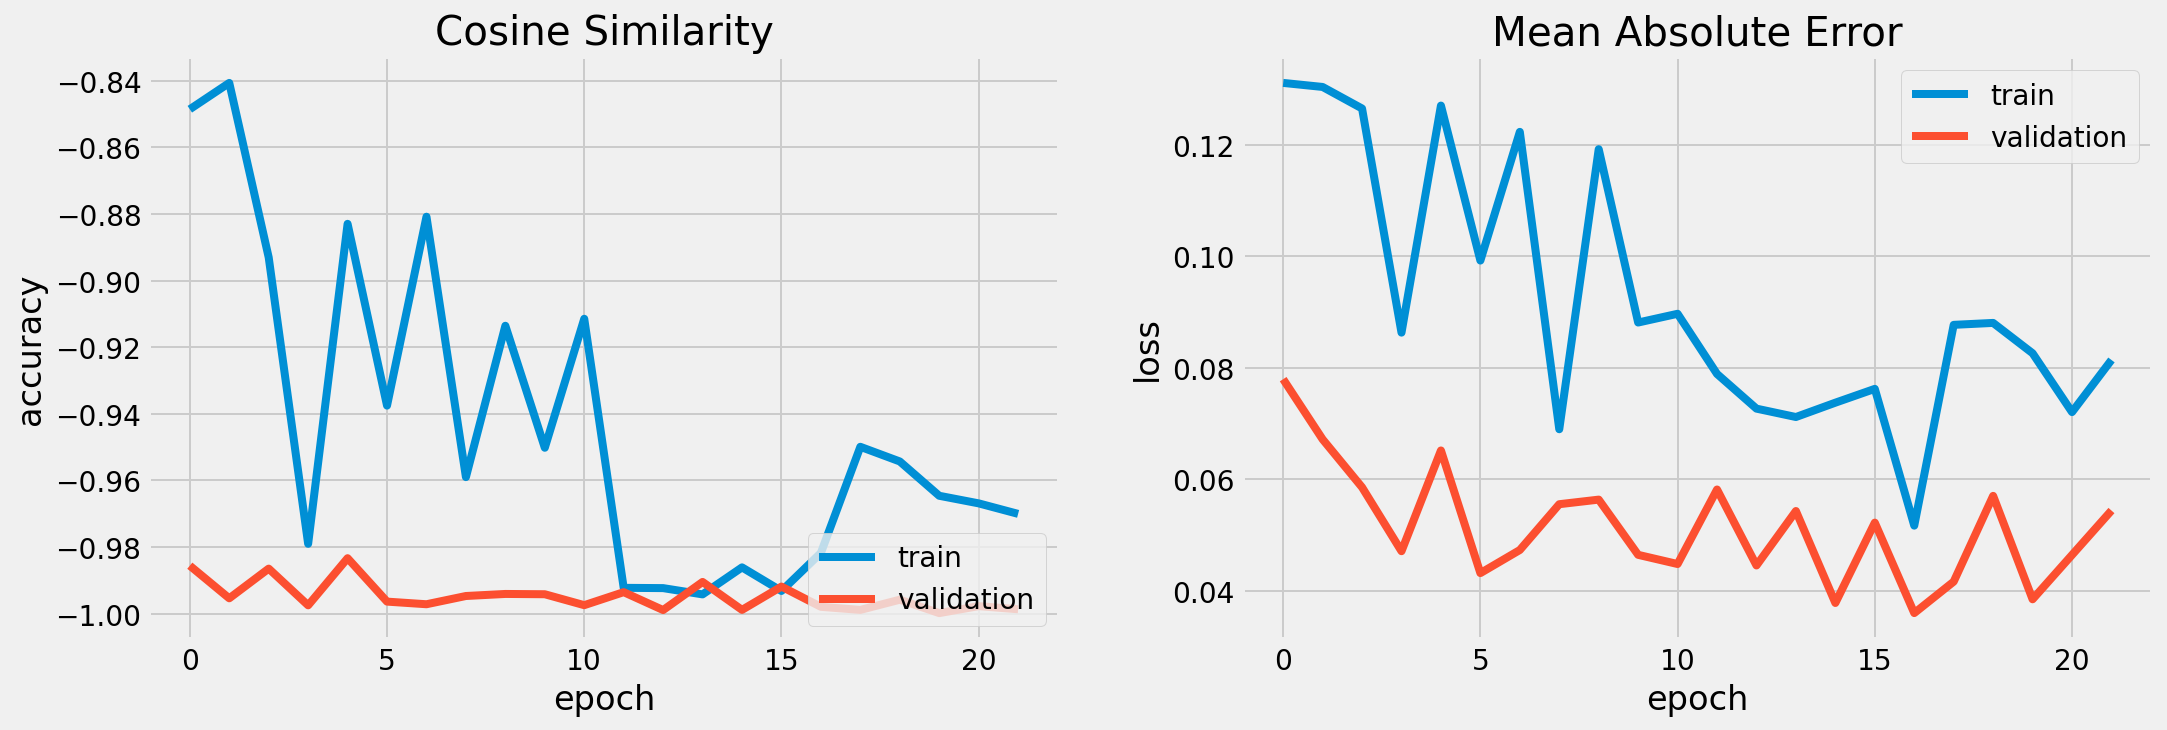

In [26]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['val_cosine_proximity'])
plt.plot(history.history['cosine_proximity'])
plt.title('Cosine Similarity')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

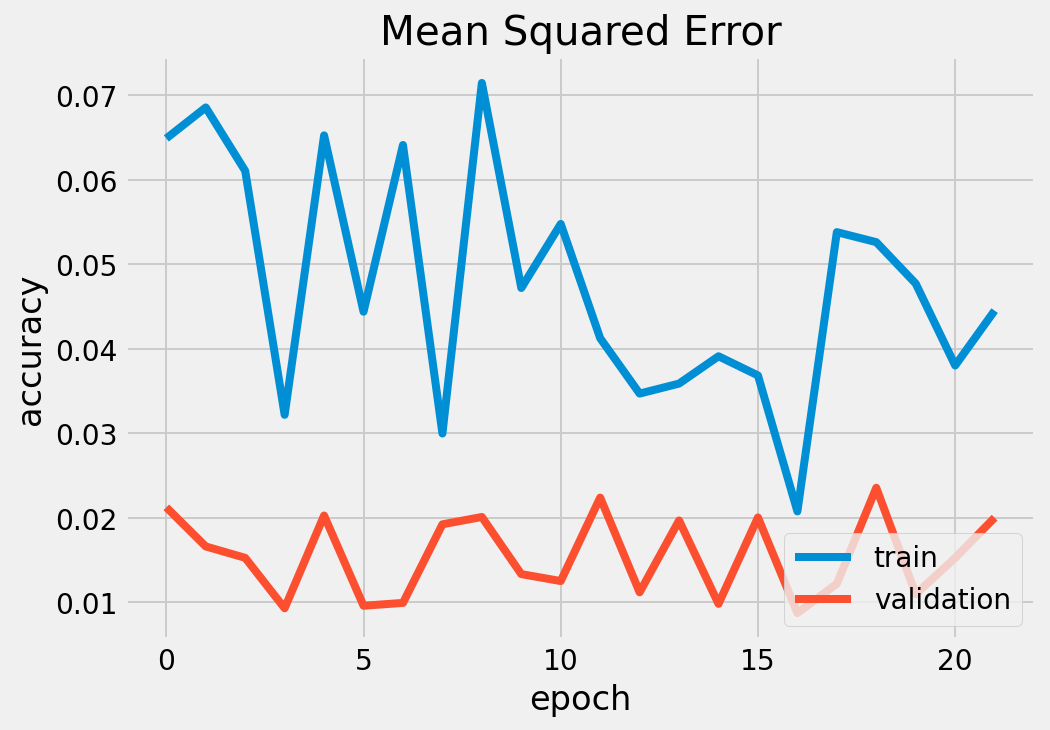

In [27]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('Mean Squared Error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')